In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
#imports for applying the naive bayes model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics
from sklearn import preprocessing

Loading the required CSVs

In [4]:
pop_df = pd.read_csv('population_india_census2011.csv')
pop_df = pop_df.rename(columns = {"State / Union Territory": "detected_state"})

In [5]:
individual_df = pd.read_csv('IndividualDetails.csv')

In [34]:
individual_df.count()

id                    3671
government_id          817
diagnosed_date        3671
age                   3671
gender                3671
detected_city          822
detected_district     2744
detected_state        3671
nationality            427
current_status        3671
status_change_date    3570
notes                 2640
Unnamed: 12             42
age_group             3671
days_to_change        3671
dtype: int64

In [6]:
# filling in missing data using the most occurring data.
individual_df["age"] = individual_df['age'].fillna(24)
#individual_df['age'] = individual_df['age'].astype(str)
#individual_df['age'] = individual_df['age'].apply(lambda x : 24 if x=="nan" else x)
individual_df['age'] = individual_df['age'].apply(pd.to_numeric) 
individual_df = individual_df.assign(age_group = individual_df['age']//10)

In [7]:
individual_df['gender'] = individual_df['gender'].astype(str)
individual_df['gender'] = individual_df['gender'].apply(lambda x : "M" if x=="nan" else x)

In [8]:
#days_to_change is the number of days taken by the patient to be declared Recovered or Deceased

individual_df['diagnosed_date'] = pd.to_datetime(individual_df['diagnosed_date'],dayfirst=True)
individual_df['status_change_date'] = pd.to_datetime(individual_df['status_change_date'], dayfirst=True)
individual_df = individual_df.assign(days_to_change = individual_df['status_change_date'] - individual_df['diagnosed_date'])
individual_df["days_to_change"]= individual_df["days_to_change"].apply(lambda x : x.days//5)
individual_df["days_to_change"] =  individual_df["days_to_change"].fillna(0)

In [26]:
#pop_df = pop_df.rename(columns = {"State / Union Territory": "detected_state"}) 
df = pd.merge(individual_df, pop_df[['detected_state','Density']], how='inner', on='detected_state')

In [27]:
df = df.drop(['government_id','detected_district','nationality','age','id','Density',
              'government_id','Unnamed: 12','status_change_date','diagnosed_date','detected_city'], axis = 1)
df.head()
df.dtypes

gender             object
detected_state     object
current_status     object
notes              object
age_group         float64
days_to_change    float64
dtype: object

In [28]:
def assignCat(row) :
    
    if row['days_to_change'] > 2 and row['current_status'] == "Recovered" : 
        return 2
    elif row['current_status'] == "Deceased":
        return 1
    else :
        return 3

In [29]:
df['category'] = df.apply(lambda row : assignCat(row), axis = 1) 
df.head()

,gender,detected_state,current_status,notes,age_group,days_to_change,category
0,F,Kerala,Recovered,Travelled from Wuhan,2.0,3.0,2
1,M,Kerala,Recovered,Travelled from Wuhan,2.0,2.0,3
2,M,Kerala,Recovered,Travelled from Wuhan,2.0,2.0,3
3,M,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha,2.0,3.0,2
4,M,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha,5.0,4.0,2


In [30]:
import re
df['notes_category'] =  df['notes']
index = {
    "suspect":['mumbai','delhi','mh','up','maharastra','kerala','chennai','patient'],
    "high_risk":['airport','foreign','confirmed','dubai','iran','bahrain','us','covid','wuhan','china','uae','kenya','italy','spain','positive','hospital','saudi','thailand','usa','france','germany','uk','london','qatar','paris','lanka','middle','east','hospital','admitted','turkey','mecca','mexico','japan','indonesian','indonesia','philippines','singapore'],
}

for i,note in enumerate(df['notes'].astype('str')):
    df['notes_category'][i] = 'safe'
    words = note.strip().split(' ')
    for word in words:
        word = word.strip(',').lower()
        if word in index['suspect']:
            df['notes_category'][i] = 'suspect'
            break
        elif word in index['high_risk']:
            df['notes_category'][i] = 'high_risk'
            break
        else:
            rexp = re.compile(r"P[0-9]+$")
            if rexp.search(word):
                df['notes_category'][i] = 'suspect'
                break
    

print(df.head())


/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


  gender detected_state current_status  \
0      F         Kerala      Recovered   
1      M         Kerala      Recovered   
2      M         Kerala      Recovered   
3      M         Kerala      Recovered   
4      M         Kerala      Recovered   

                                             notes  age_group  days_to_change  \
0                             Travelled from Wuhan        2.0             3.0   
1                             Travelled from Wuhan        2.0             2.0   
2                             Travelled from Wuhan        2.0             2.0   
3  Travelled from Italy on 29/02/2020 through Doha        2.0             3.0   
4  Travelled from Italy on 29/02/2020 through Doha        5.0             4.0   

   category notes_category  
0         2      high_risk  
1         3      high_risk  
2         3      high_risk  
3         2      high_risk  
4         2      high_risk  


In [31]:
df['Symptoms'] = df['category']
df['Symptoms_category'] = df['category']

index = {
    'suspect':['mild fever','cold','flu','dizzyness','strong headache','dehydration'],
    'high_risk':['dry cough','breathlessness','high fever']
}

from random import random

for i,symptom in enumerate(df['Symptoms']):
    if df['category'][i] == 1:
        df['Symptoms_category'][i] = 'High_risk'
        
        no_of_symptoms = int(random()*100%4)
        symptoms = ''
        for j in range(0,no_of_symptoms):
            symptoms = symptoms + index['high_risk'][j] + ','
            
        symptoms = symptoms[:-1]
        df['Symptoms'][i] = symptoms
        
    elif df['category'][i] == 2:
        df['Symptoms_category'] = 'Suspect'
        no_of_symptoms = int(random()*100%7)
        symptoms = ''
        for j in range(0,no_of_symptoms):
            symptoms = symptoms + index['suspect'][j] + ','
            
        symptoms = symptoms[:-1]
        df['Symptoms'][i] = symptoms
        
    else:
        df['Symptoms'][i] = 'No flu Symptoms'
        df['Symptoms_category'][i] = 'Safe'
        
        
df.head()

/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chaitya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a 

,gender,detected_state,current_status,notes,age_group,days_to_change,category,notes_category,Symptoms,Symptoms_category
0,F,Kerala,Recovered,Travelled from Wuhan,2.0,3.0,2,high_risk,"mild fever,cold,flu,dizzyness,strong headache",Suspect
1,M,Kerala,Recovered,Travelled from Wuhan,2.0,2.0,3,high_risk,No flu Symptoms,Suspect
2,M,Kerala,Recovered,Travelled from Wuhan,2.0,2.0,3,high_risk,No flu Symptoms,Suspect
3,M,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha,2.0,3.0,2,high_risk,mild fever,Suspect
4,M,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha,5.0,4.0,2,high_risk,"mild fever,cold,flu,dizzyness,strong headache,...",Suspect


In [32]:
df.to_csv('dataset.csv') 

In [33]:
df.count()

gender               3399
detected_state       3399
current_status       3399
notes                2443
age_group            3399
days_to_change       3399
category             3399
notes_category       3399
Symptoms             3399
Symptoms_category    3399
dtype: int64

In [2]:
df = pd.read_csv('dataset.csv')
df = df.drop(['Symptoms','notes'], axis = 1)

In [5]:
df = df[df.days_to_change >= 0]
le = preprocessing.LabelEncoder()
encodings = dict()

df['gender'] = le.fit_transform(df['gender'])
gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
encodings['gender'] = gender_mapping

df['notes_category'] = le.fit_transform(df['notes_category'])
notes_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
encodings['notes'] = notes_mapping

df['Symptoms_category'] = le.fit_transform(df['Symptoms_category'])
symptom_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
encodings['symptoms'] = symptom_mapping

df['detected_state'] = le.fit_transform(df['detected_state'])
state_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
encodings['state'] = state_mapping

df['current_status'] = le.fit_transform(df['current_status'])
status_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
encodings['status'] = status_mapping

print(encodings)
df.head()

{'gender': {'F': 0, 'M': 1}, 'notes': {'high_risk': 0, 'safe': 1, 'suspect': 2}, 'symptoms': {'High_risk': 0, 'Safe': 1, 'Suspect': 2}, 'state': {'Andaman and Nicobar Islands': 0, 'Andhra Pradesh': 1, 'Arunachal Pradesh': 2, 'Assam': 3, 'Bihar': 4, 'Chandigarh': 5, 'Chhattisgarh': 6, 'Delhi': 7, 'Goa': 8, 'Gujarat': 9, 'Haryana': 10, 'Himachal Pradesh': 11, 'Jammu and Kashmir': 12, 'Jharkhand': 13, 'Karnataka': 14, 'Kerala': 15, 'Ladakh': 16, 'Madhya Pradesh': 17, 'Maharashtra': 18, 'Manipur': 19, 'Mizoram': 20, 'Odisha': 21, 'Puducherry': 22, 'Punjab': 23, 'Rajasthan': 24, 'Tamil Nadu': 25, 'Uttar Pradesh': 26, 'Uttarakhand': 27, 'West Bengal': 28}, 'status': {'Deceased': 0, 'Hospitalized': 1, 'Migrated': 2, 'Recovered': 3}}


,gender,detected_state,current_status,age_group,days_to_change,notes_category,Symptoms_category,category
0,0,15,3,2,3,0,2,2
1,1,15,3,2,2,0,2,3
2,1,15,3,2,2,0,2,3
3,1,15,3,2,3,0,2,2
4,1,15,3,5,4,0,2,2


In [6]:
df.count(axis='index')

gender               3395
detected_state       3395
current_status       3395
age_group            3395
days_to_change       3395
notes_category       3395
Symptoms_category    3395
category             3395
dtype: int64

In [7]:
# store the feature matrix (X) and response vector (y) 
X = df.loc[:,:'Symptoms_category']
y = df['category'] 

# splitting X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
  
# training the model on training set 
gnb = MultinomialNB() 
gnb.fit(X_train, y_train) 
  
# making predictions on the testing set 
y_pred = gnb.predict(X_test) 
  
# comparing actual response values (y_test) with predicted response values (y_pred) 
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)


Gaussian Naive Bayes model accuracy(in %): 98.5279685966634


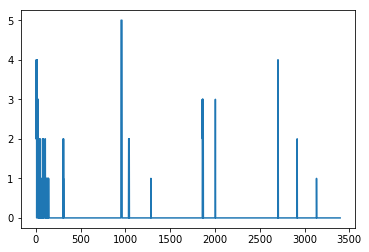

In [169]:
plt.plot(df["days_to_change"])
plt.show()


In [35]:
individual_df.to_csv('file1.csv') 

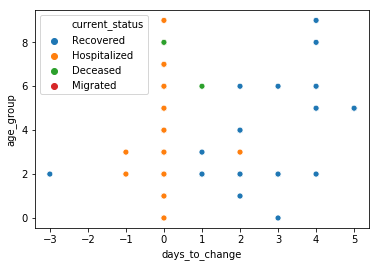

In [16]:
sns.scatterplot(y='age_group',x='days_to_change',hue='current_status',data=df)

In [66]:
df.describe()

,age_group,days_to_change
count,3399.000000,3298.000000
mean,2.378347,0.344754
std,1.065186,2.423911
min,0.000000,-12.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,0.000000
max,9.000000,25.000000


In [71]:
df[df['current_status'] == 'Deceased']

,diagnosed_date,gender,detected_city,detected_state,current_status,status_change_date,notes,Unnamed: 12,age_group,days_to_change,Density
63,2020-03-22,M,,Kerala,Deceased,2020-03-28,Travelled from Dubai,NaN,6.0,6.0,"859/km2 (2,220/sq mi)"
200,2020-03-29,M,NaN,Kerala,Deceased,2020-03-31,Details awaited,NaN,6.0,2.0,"859/km2 (2,220/sq mi)"
311,2020-03-12,F,Janakpuri,Delhi,Deceased,2020-03-12,Mother of P64,NaN,6.0,0.0,"11,297/km2 (29,260/sq mi)"
793,2020-03-26,NaN,NaN,Rajasthan,Deceased,2020-03-27,Details Awaited,NaN,2.0,1.0,201/km2 (520/sq mi)
1294,2020-03-23,M,Madurai,Tamil Nadu,Deceased,2020-03-25,Annanagar at Rajaji Hosp. No mention of travel...,NaN,5.0,2.0,"555/km2 (1,440/sq mi)"
1772,2020-03-24,M,NaN,Jammu and Kashmir,Deceased,2020-03-24,Travel History (attended religious event),NaN,6.0,0.0,98/km2 (250/sq mi)
1865,2020-03-12,M,Kalaburagi,Karnataka,Deceased,2020-03-12,"Travelled from Saudi on Feb 29, First death in...",NaN,7.0,0.0,319/km2 (830/sq mi)
1912,2020-03-26,F,NaN,Karnataka,Deceased,2020-03-26,"Travelled from Mecca, Saudi Arabia, details aw...",NaN,7.0,0.0,319/km2 (830/sq mi)
1919,2020-03-27,M,Tumkur,Karnataka,Deceased,2020-03-27,History of travel to Delhi,NaN,6.0,0.0,319/km2 (830/sq mi)
1984,2020-04-03,M,NaN,Karnataka,Deceased,2020-04-03,NaN,NaN,7.0,0.0,319/km2 (830/sq mi)
